In [14]:
%matplotlib nbagg
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm

# 8 The Lapped Bi-orthogonal Transform (LBT)

<div class="alert alert-warning alert-block">
    
This notebook is incomplete!</div>

<p></p>

<!-- sorry for the nasty HTML, markdown is bad for figures -->

<figure style="text-align: center">
<div class="row">
<figure class="col-md-4 col-md-offset-1">
<img src="figures/lbt.png" style="max-height: 350px" />
<figcaption>(a) Lapped Bi-orthogonal Transform</figcaption>
</figure>

<figure class="col-md-5 col-md-offset-1">
<img src="figures/pot.png" style="max-height: 350px" />
<figcaption>(b) Photo Overlap Transform and a DCT</figcaption>
</figure>
</div>
<div class="row">
<figcaption>
<br />

Figure 4: (a) An LBT transforms overlapping sections of `X` to create `Y`. (b) In some cases
this can be interpreted as pre-filtering with a POT, followed by a DCT.</figcaption></div></figure>

One of the difficulties with the DCT is that it processes each block separately and hence
does not take advantage of any correlation between blocks. A possible solution to this is
to use a _Lapped Bi-orthogonal Transform (LBT)_. These transform overlapping blocks in `X`
to generate smaller non-overlapping blocks in `Y`. In the left-hand figure above, 16 values
in `X` are used to generate each set of 8 values in `Y`.

LBTs are quite complicated to derive and analyse: however one of the most popular forms<sup>3</sup>
can also be represented as a pre-filtering operation before performing the DCT described
in the previous section.
In this case the pre-filtering (or post-filtering for the reverse
operation) is sometimes known as a _Photo Overlap Transform or POT_. A POT followed
by a DCT is then equivalent to a particular type of LBT.

The right-hand figure above demonstrates this. The POT is first performed on a section
of data `X`, shifted by `N/2`, so that it runs across the block boundaries of the subsequent
DCT. Ignoring this block shift for a moment, the forward operation for a 2D image `X` is:


$$Y = C ∗ Pf ∗ X ∗ Pf ′ ∗ C′$$

or in reverse

$$ X = Pr′ ∗ C′ ∗ Y ∗ C ∗ Pr $$

<hr />
<small><sup>3</sup>The type-II fast lapped (bi-)orthogonal transform, or LOT-II</small>

## 8.1 Applying the LBT to images

In [15]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

The pre-filtering `Pf ∗ X ∗ Pf′` (with the correct block shift) is straightforward in Python:

```python
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
```

This is followed by the DCT `C` as before. In the reverse operation, the inverse DCT `C’` is
performed first, followed by Pr’:
```python
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
```

We have provided a function `pot_ii(N, s)` which will generate a forward (pre-filtering,
`Pf`) and reverse (post-filtering, `Pr`) matrix of size `N` with scaling factor `s`.

In [16]:
from cued_sf2_lab.lbt import pot_ii

In [17]:
IPython.display.Code(inspect.getsource(pot_ii), language="python")

def pot_ii(N, s=(1+(5**0.5))/2, overlap=None):
    """
    Generates the 1-D POT transform matrices of size N

    Equivalent to the pre-filtering stage of a Type-II fast
    Lapped Orthogonal Transform (LOT-II).

    POT_II Photo Overlap Transform matrix

    Y = Pf * X pre-filters N-vector X into Y.
    X = Pr' * Y post-filters N-vector Y into X.

    Parameters:
    N (int): Size of DCT used
    s (float): Scaling factor determining the orthogonality of the transform.
    s=1 generates a LOT (Pr = Pf), otherwise 1<s<2 generates
    an LBT. The default is the Golden Ratio, (1+5^0.5)/2.
    overlap (int): Determines amount of overlap. 0<overlap<=N/2.
    Default is N/2, which implies complete overlap with the corresponding DCT

    Returns:
    Pf (np.ndarray): Prefiltering matrix
    Pr (np.ndarray): Postfiltering matrix

    """
    # ensure N is divisible 2 and is an integer
    if N % 2 != 0 or type(N) != int:
        raise ValueError('N must be an integer divisible by 2.')
    if overlap is None:
        # produces an integer which survives next test
        overlap = N//2
    else:
        try:
            overlap = operator.index(overlap)
        except TypeError as e:
            raise TypeError('overlap must be an integer') from e
    # TODO: Ask Joan whether the lower limit is 0 or 1. She said 0 for now.
    if overlap > N/2 or overlap < 0:
        raise ValueError('overlap must satisfy 0<overlap<=N/2')
    # generate identity matrix
    Id = np.identity(N//2)
    # print('I', Id)
    # flip identity in the left/right direction
    J = np.fliplr(Id)

    Z = np.zeros((N//2, N//2))
    C_ii = dct_ii(overlap)
    # print('C_ii', C_ii)
    C_iv = dct_iv(overlap)
    # print('C_iv', C_iv)

    # generate forward and reverse scaling matrices
    # use a list to be able to concatenate
    diag_ones = [1 for i in range(overlap-1)]
    Sf = np.diag([s]+diag_ones)
    Sr = np.diag([1/s]+diag_ones)

    # generate forward and reverse filtering matrices
    if overlap < N/2:
        VI = np.identity((N//2)-overlap)
        VJ = np.fliplr(VI)
        VZ = np.zeros((overlap, (N//2)-overlap))
        Vf = np.block([
            [VJ @ C_ii.T @ Sf @ C_iv @ VJ, VZ],
            [VZ.T, VI]])
        # for Vr
        Vr = np.block([
            [VJ @ C_ii.T @ Sr @ C_iv @ VJ, VZ],
            [VZ.T, VI]])

    else:
        Vf = J @ C_ii.T @ Sf @ C_iv @ J
        Vr = J @ C_ii.T @ Sr @ C_iv @ J
    # create component matrices to build Pf and Pr
    mtrx_1 = np.block([[Id, J], [J, -Id]])
    pf_1 = np.block([[Id, Z], [Z, Vf]])
    pr_1 = np.block([[Id, Z], [Z, Vr]])

    Pf = 0.5*(mtrx_1 @ pf_1 @ mtrx_1)
    Pr = 0.5*(mtrx_1 @ pr_1 @ mtrx_1)
    return Pf, Pr

Edit your code
for performing DCT analysis so that it can pre-filter `X` with `Pf` before the forward DCT,
then post-filter `Z` with `Pr` after the inverse DCT. Confirm that, without quantisation, this
correctly recreates the original image, i.e. `Zp = X`. Use `Pf, Pr = pot_ii(N)` with the
default scaling value `s`.

In [18]:
# your code here
from cued_sf2_lab.dct import dct_ii
from cued_sf2_lab.dct import regroup
N=8 #dct size
Pf, Pr = pot_ii(N) #filter with default s

#pre filtering
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
#dct
C8 = dct_ii(8)
Y = colxfm(colxfm(Xp, C8).T, C8).T
Yr = regroup(Y, N)/N
#inverse dct
Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)
#post filtering
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
print("maximum absolute error between X and Zp :")
print(np.max(abs(X-Zp)))

maximum absolute error between X and Zp :
7.958078640513122e-13


<IPython.core.display.Javascript object>


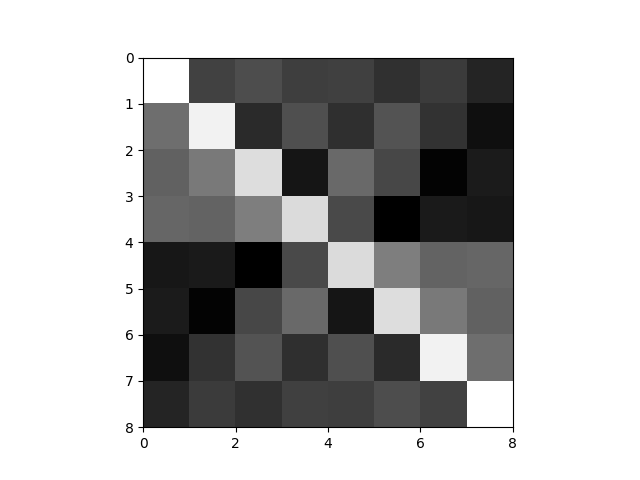

In [19]:
Pf, Pr = pot_ii(N,2)
fig, ax = plt.subplots()
plot_image(Pf, ax=ax);

<IPython.core.display.Javascript object>


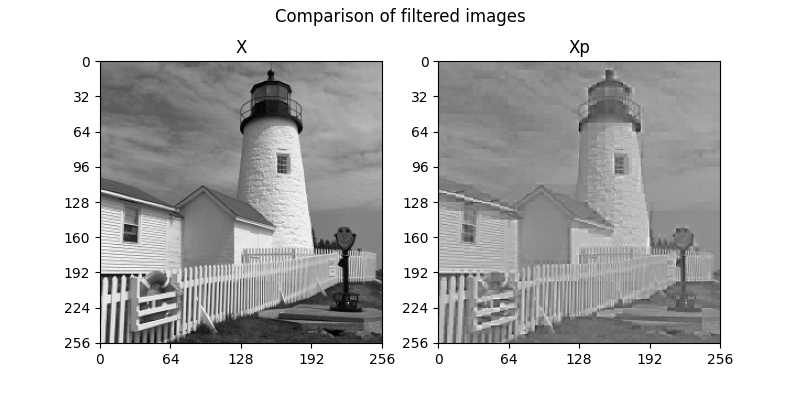

[Text(0.5, 1.0, 'Xp')]

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # this demonstrates how to plot multiple figures side-by-side
fig.suptitle('Comparison of filtered images')
plot_image(X, ax=axs[0], cmap=cmaps_dict['map'])
axs[0].set(title='X')
plot_image(Xp, ax=axs[1], cmap=cmaps_dict['map'])
axs[1].set(title='Xp')


## 8.2 Quantisation and coding efficiency

The scaling factor `s` determines the degree of bi-orthogonality. If `s = 1` then Pf is the same
as Pr, otherwise `1 < s < 2` weights the relative contributions of `Pf` and `Pr` un-equally.

<div class="alert alert-block alert-danger">

For an 8 × 8 DCT, try implementing an LBT with POT scaling factors varying from $1$
to $2$ ($\sqrt{2}$ is often a good choice). In each case find the quantisation step which makes
the rms error match the directly quantised image. Note the compression ratios and find
the scaling factor which maximises these. Also note the visual features in these images.</div>

In [30]:
#step optimisation
def get_step_size(X, C, s, N, acc,ratios=[1,1,1,1,1]):
    #prefilter
    Pf, Pr = pot_ii(N,s)
    t = np.s_[N//2:-N//2]
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
    Y = colxfm(colxfm(Xp, C).T, C).T #dct
    
    X_quantised = quantise(X, 17)
    direct_rms = np.std(X - X_quantised)
    steps= np.arange(1, 30.0, acc)
    rms_diffenences = [] #initiate
    rms=[]
    #print(f'Direct RMS Error: {direct_rms}')
    for step in steps:
        Yq = quantise(Y, step*ratios[0])
        Zq = colxfm(colxfm(Yq.T, C.T).T, C.T)#reverse dct
        #post filtering
        Zqp = Zq.copy()  #copy the non-transformed edges directly from Z
        Zqp[:,t] = colxfm(Zqp[:,t].T, Pr.T).T
        Zqp[t,:] = colxfm(Zqp[t,:], Pr.T)
        rms.append(np.std(Zqp - X))
        rms_diffenences.append(abs(direct_rms-np.std(Zqp - X)))
    #print(f'Index of optimum: {np.argmin(rms_diffenences)}')
    print(f'Optimum Step Size: {steps[np.argmin(rms_diffenences)]}')
    #print(f'Optimum RMS Error: {rms[np.argmin(rms_diffenences)]}')
    #print(f'Optimum RMS Error difference (with original): {rms_diffenences[np.argmin(rms_diffenences)]}')

    return steps[np.argmin(rms_diffenences)]

#bits of regroup images
def dctbpp(Yr, N):
    gaps = np.linspace(0,256,N+1)
    BYr = 0
    for i in range(N):
        for j in range(N):
            Ys = Yr[int(gaps[i]):int(gaps[i+1]),int(gaps[j]):int(gaps[j+1])]
            BYs = bpp(Ys) * Ys.shape[0] * Ys.shape[1]
            BYr += BYs
    return BYr

In [36]:
# your code here
from cued_sf2_lab.laplacian_pyramid import bpp
from cued_sf2_lab.laplacian_pyramid import quantise
#direct
Xq = quantise(X, 17)
tbppX = bpp(Xq)*Xq.shape[0]*Xq.shape[1]
print(f'Direct quantised bits:')
print(tbppX)

N=8 #dct size
C8 = dct_ii(8)

t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size

print('**********')
print('s=1 ')
Pf, Pr = pot_ii(N,1) #filter with different s

#pre filtering
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

#dct
Y = colxfm(colxfm(Xp, C8).T, C8).T
Yq = quantise(Y, get_step_size(X, C8,1, 8,0.1))
Yr = regroup(Yq, N)/N
print(f'DCT quantised bits:')
print(dctbpp(Yr, 8))
#inverse dct
Zq1 = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
#post filtering
Zqp1 = Zq1.copy()  #copy the non-transformed edges directly from Z
Zqp1[:,t] = colxfm(Zqp1[:,t].T, Pr.T).T
Zqp1[t,:] = colxfm(Zqp1[t,:], Pr.T)
print('Compression Ratio:')
print(tbppX/dctbpp(Yr, 8))

print('**********')
print('s=2 ')
Pf, Pr = pot_ii(N,2) #filter with different s

#pre filtering
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
#dct
Y = colxfm(colxfm(Xp, C8).T, C8).T
Yq = quantise(Y, get_step_size(X, C8, 2,8,0.1))
Yr = regroup(Yq, N)/N
print('DCT quantised bits:')
print(dctbpp(Yr, 8))
#inverse dct
Zq2 = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
#post filtering
Zqp2 = Zq2.copy()  #copy the non-transformed edges directly from Z
Zqp2[:,t] = colxfm(Zqp2[:,t].T, Pr.T).T
Zqp2[t,:] = colxfm(Zqp2[t,:], Pr.T)
print('Compression Ratio:')
print(tbppX/dctbpp(Yr, 8))

print('**********')
print(f's=1.33 ')
Pf, Pr = pot_ii(N,1.33) #filter with different s

#pre filtering
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
#dct
Y = colxfm(colxfm(Xp, C8).T, C8).T
Yq = quantise(Y, get_step_size(X, C8,1.33,8, 0.1))
Yr = regroup(Yq, N)/N
print(f'DCT quantised bits:')
print(dctbpp(Yr, 8))
#inverse dct
Zq3 = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
#post filtering
Zqp3 = Zq3.copy()  #copy the non-transformed edges directly from Z
Zqp3[:,t] = colxfm(Zqp3[:,t].T, Pr.T).T
Zqp3[t,:] = colxfm(Zqp3[t,:], Pr.T)
print('Compression Ratio:')
print(tbppX/dctbpp(Yr, 8))

Direct quantised bits:
228119.03651868744
**********
s=1 
Optimum Step Size: 23.40000000000002
DCT quantised bits:
75446.95069747364
Compression Ratio:
3.0235686718923427
**********
s=2 
Optimum Step Size: 26.400000000000023
DCT quantised bits:
79890.58772860437
Compression Ratio:
2.8553931446045766
**********
s=1.33 
Optimum Step Size: 25.600000000000023
DCT quantised bits:
72661.34461040045
Compression Ratio:
3.1394827296663514


<IPython.core.display.Javascript object>


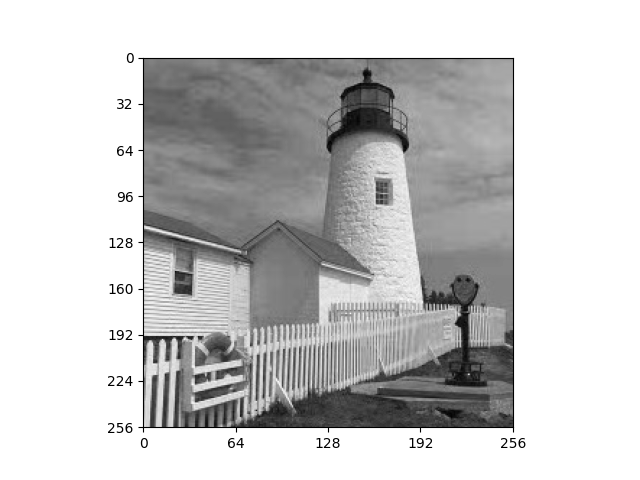

In [39]:
fig, ax = plt.subplots()
plot_image(Zqp1, ax=ax);

In [23]:
s_values=[]
CRs=[]
for i in np.arange(1, 2, 0.01):
    s_values.append(i)
    Pf, Pr = pot_ii(N,i) #filter with different s

    #pre filtering
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
    #dct
    Y = colxfm(colxfm(Xp, C8).T, C8).T
    Yq = quantise(Y, get_step_size(X, C8, i,8, 0.1))
    Yr = regroup(Yq, N)/N

    #inverse dct
    Zq = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
    #post filtering
    Zqp = Zq.copy()  #copy the non-transformed edges directly from Z
    Zqp[:,t] = colxfm(Zqp[:,t].T, Pr.T).T
    Zqp[t,:] = colxfm(Zqp[t,:], Pr.T)
    CRs.append(tbppX/dctbpp(Yr, 8))

In [24]:
print(CRs[np.argmax(CRs)])
print(s_values[np.argmax(CRs)])

3.1394827296663514
1.3300000000000003


<IPython.core.display.Javascript object>


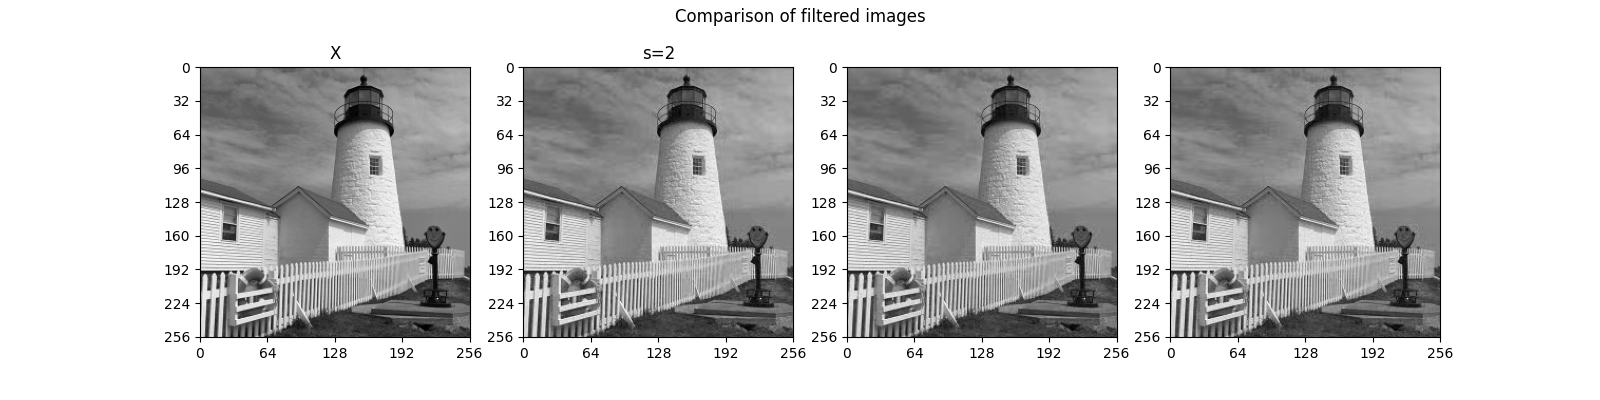

[Text(0.5, 1.0, 's=2')]

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # this demonstrates how to plot multiple figures side-by-side
fig.suptitle('Comparison of filtered images')
plot_image(X, ax=axs[0], cmap=cmaps_dict['map'])
axs[0].set(title='X')
plot_image(Zqp1, ax=axs[1], cmap=cmaps_dict['map'])
axs[1].set(title='s=1')
plot_image(Zqp3, ax=axs[2], cmap=cmaps_dict['map'])
axs[1].set(title='s=1.33')
plot_image(Zqp2, ax=axs[3], cmap=cmaps_dict['map'])
axs[1].set(title='s=2')

The POT can often improve both compression and block smoothing, since the pre-filter
acts to reduce correlations between each DCT sub-block, whilst the inverse post-filter
acts to remove the discontinuities between sub-blocks. This is rather different from the
operation of the DCT. Investigate this by looking at the basis functions, as you did with
the DCT:

<IPython.core.display.Javascript object>


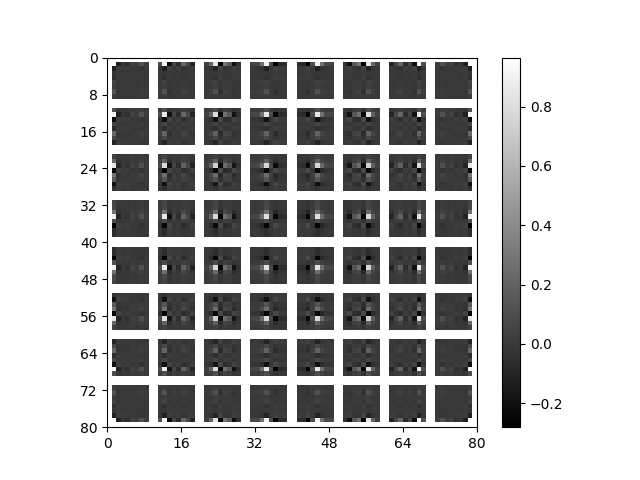

In [47]:
Pf, Pr = pot_ii(8,1)
bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
fig, ax = plt.subplots()
im_obj = plot_image(bases @ bases.T, ax=ax)
fig.colorbar(im_obj, ax=ax);

<IPython.core.display.Javascript object>


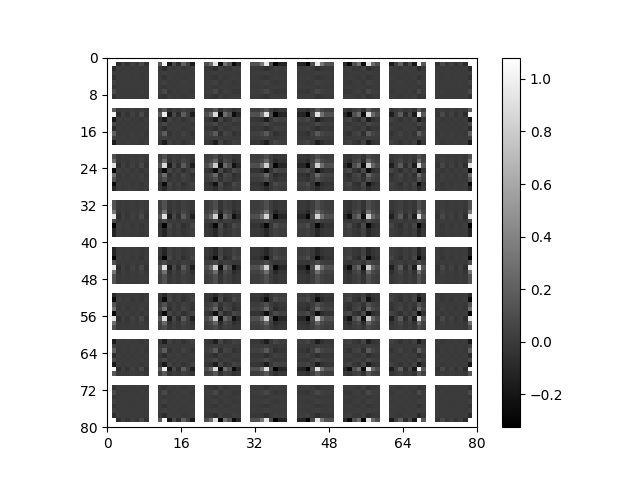

In [45]:
Pf, Pr = pot_ii(8,1.33)
bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
fig, ax = plt.subplots()
im_obj = plot_image(bases @ bases.T, ax=ax)
fig.colorbar(im_obj, ax=ax);

<div class="alert alert-block alert-danger">

Look at both these bases and the pre-filtered image `Xp`, using different scaling factors
`s`, and comment on the visual effect of varying these scaling factors. You may need to
multiply `Xp` by up to 0.5 to display it better.</div>

**********
s=1 
**********
s=1.33 


<IPython.core.display.Javascript object>


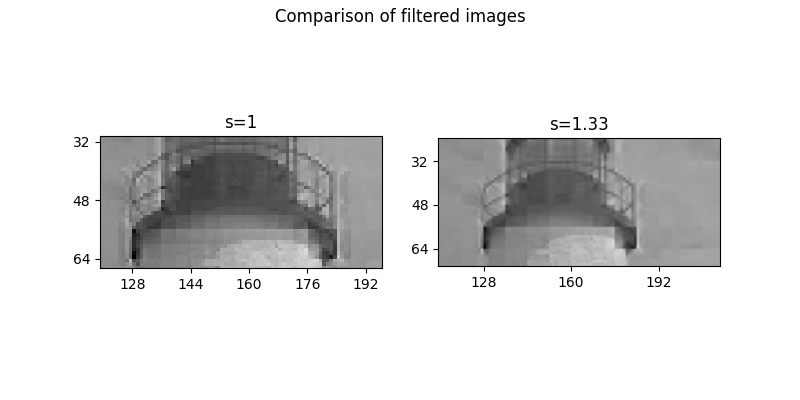

[Text(0.5, 1.0, 's=1.33')]

In [49]:
# your code here
N=8
print('**********')
print('s=1 ')
Pf, Pr = pot_ii(N,1) #filter with different s

#pre filtering
Xp1 = X.copy()  # copy the non-transformed edges directly from X
Xp1[t,:] = colxfm(Xp1[t,:], Pf)
Xp1[:,t] = colxfm(Xp1[:,t].T, Pf).T
Xp1 = Xp1*0.3
print('**********')
print('s=1.33 ')
Pf, Pr = pot_ii(N,1.33) #filter with different s

#pre filtering
Xp2 = X.copy()  # copy the non-transformed edges directly from X
Xp2[t,:] = colxfm(Xp2[t,:], Pf)
Xp2[:,t] = colxfm(Xp2[:,t].T, Pf).T
Xp2 = Xp2*0.3
fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # this demonstrates how to plot multiple figures side-by-side
fig.suptitle('Comparison of filtered images')
plot_image(Xp1, ax=axs[0], cmap=cmaps_dict['map'])
axs[0].set(title='s=1')
plot_image(Xp2, ax=axs[1], cmap=cmaps_dict['map'])
axs[1].set(title='s=1.33')

<IPython.core.display.Javascript object>


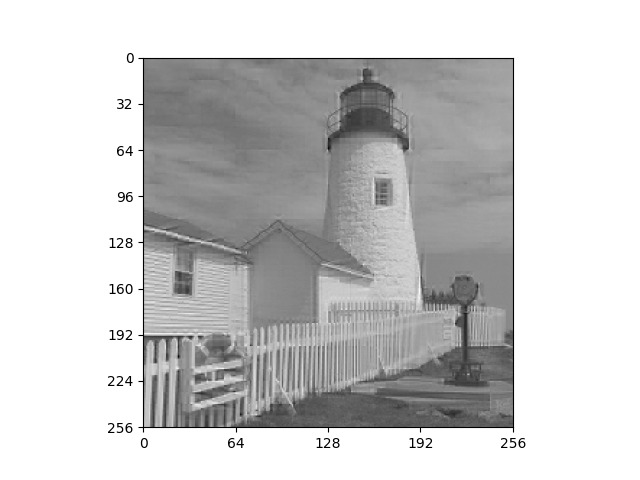

In [48]:
fig, ax = plt.subplots()
plot_image(Xp1, ax=ax);

With this type of POT / DCT combination it is common to use smaller DCT block sizes
but to code several blocks together. Hence a more accurate estimate of the number of bits
is found by always using 16 × 16 blocks, i.e. regroup `Yq` with the correct size `N` to give
`Yr`, but then always use `dctbpp(Yr, 16)`.

<div class="alert alert-block alert-danger">

Investigate the relative visual and compression performance of LBTs with 4 × 4, 8 × 8
and 16 × 16 blocks, using the scaling factor you have previously selected. As before, be
careful to match the rms error with a directly quantised image.</div>

<IPython.core.display.Javascript object>


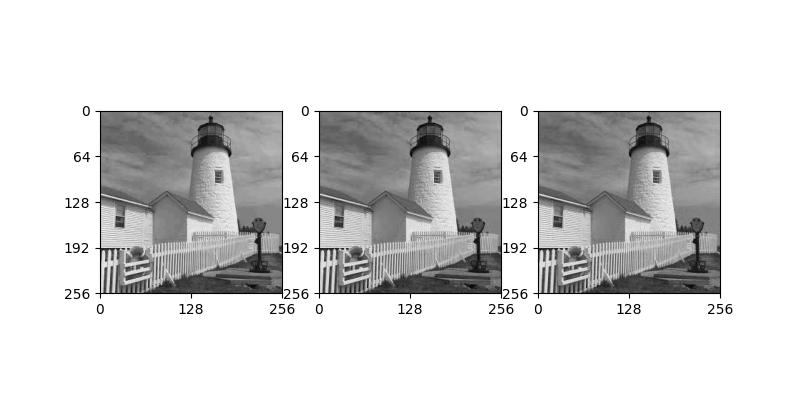

Optimum Step Size: 28.200000000000024
The compression ratio for 4X4 DCTS is 3.5636192204269936
Optimum Step Size: 25.600000000000023
The compression ratio for 8X8 DCTS is 3.427809470502411
Optimum Step Size: 22.80000000000002
The compression ratio for 16X16 DCTS is 2.948017515886274


In [50]:
# your code here
N_values = [4,8,16]
fig,axs = plt.subplots(1,3,figsize=(8,4))
s=1.33684
for i in range(len(N_values)):
    N = N_values[i]
    C = dct_ii(N)
    step = get_step_size(X,C,s,N,0.1)
    Pf, Pr = pot_ii(N,s)
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
    Y = colxfm(colxfm(Xp,C).T,C).T
    Yq = quantise(Y,step)
    Yr = regroup(Yq,N)
    bits = dctbpp(Yr,16)
    tem1 = tbppX / bits
    Z = colxfm(colxfm(Yq.T,C.T).T,C.T)

    Zp = Z.copy()  #copy the non-transformed edges directly from Z
    Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:], Pr.T)

    print(f'The compression ratio for {N}X{N} DCTS is {tem1}')
    plot_image(Zp,ax=axs[i])

<IPython.core.display.Javascript object>


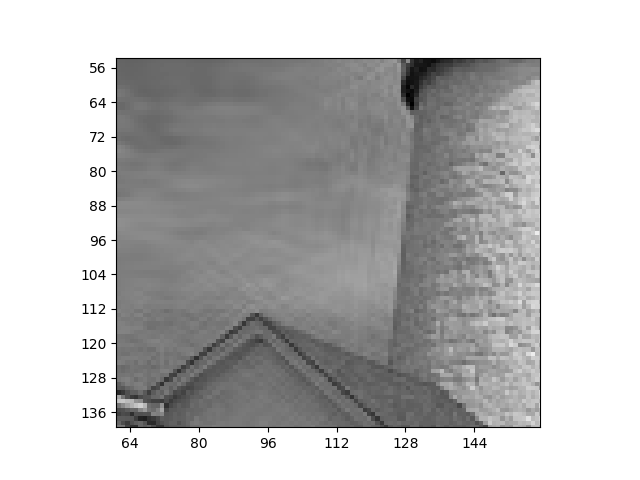

Optimum Step Size: 22.80000000000002
The compression ratio for 16X16 DCTS is 2.948017515886274
Optimum Step Size: 22.80000000000002
The compression ratio for 16X16 DCTS is 2.948017515886274
Optimum Step Size: 22.80000000000002
The compression ratio for 16X16 DCTS is 2.948017515886274


In [54]:
# your code here
N_values = [4,8,16]
fig, ax = plt.subplots()
s=1.33684
for i in range(len(N_values)):
    N = 16
    C = dct_ii(N)
    step = get_step_size(X,C,s,N,0.1)
    Pf, Pr = pot_ii(N,s)
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
    Y = colxfm(colxfm(Xp,C).T,C).T
    Yq = quantise(Y,step)
    Yr = regroup(Yq,N)
    bits = dctbpp(Yr,16)
    tem1 = tbppX / bits
    Z = colxfm(colxfm(Yq.T,C.T).T,C.T)

    Zp = Z.copy()  #copy the non-transformed edges directly from Z
    Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:], Pr.T)

    print(f'The compression ratio for {N}X{N} DCTS is {tem1}')
    plot_image(Zp,ax=axs[i])

plot_image(Zp, ax=ax);